## Dacon 청와대 청원 : 청원의 주제가 무엇일까?

https://dacon.io/competitions/open/235597/overview/description

분석목표 : 4.5만개의 청와대 청원 문자 데이터셋을 분석하여 청원 클래스를 분류

#### 제출 리더보드
***
Conv1D 모델 적용 : 2021-09-17 기준 정확도 0.878 25등

## 1. 사용 라이브러리 

In [80]:
import math
import time
from tqdm import tqdm,tqdm_pandas
## 시각화
import matplotlib.pyplot as plt
import seaborn as sns
## 전처리
import numpy as np
import pandas as pd
import re
from hanspell import spell_checker
from konlpy.tag import Mecab
## 모델링
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,Conv1D, Embedding, Dropout, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

## 2. 데이터 불러오기

In [2]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [3]:
# 4만개의 train 데이터
train

,index,category,data
0,0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...
1,1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올..."
3,3,1,"티비 12세,15세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠..."
4,4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...
...,...,...,...
39995,39995,2,시간유연근무제. 저는 국립대에서 일하고 있는 비정규직 근로자입니다.\n동시에 두 ...
39996,39996,0,소년법을 폐지해 주시고 부산 여중생 가해자 학생들의 강력한 처벌을 요구합니다. 소년...
39997,39997,2,무서운데 지켜야 할게 있어요 도와주세요. 안녕하세요 . 한부모엄마 입니다.\n양육비...
39998,39998,2,교복에 고정식 이름표를 달게 하는 것을 금지해 주세요.. 교복에 이름표를 박아놓아...


In [4]:
# 5000개의 테스트 데이터
test

,index,data
0,0,소년법 폐지해주세요. 법 아래에서 보호받아야 할 아이들이\n법으로 인해 보호받지 못...
1,1,국공립 유치원 증설에 관하여. 국공립 유치원 부지 학보와건립및 증설에\n*지역 어린...
2,2,나경원파면. 나경원의원의 동계올림픽 위원을 파면해 주세요
3,3,국민위원에가 삼성편만들어요. 삼성에서 11년간 일하고 혈암과 백혈병 진단을 받은 ...
4,4,"방과후,유치원,어린이집 영어교육을 유지시켜주세요. 저는 아이 셋 키우는 평범한 주부..."
...,...,...
4995,4995,페이스북 개인신상정보 개털렸는데 이대로... 존경하신 문재인 대통령님 ~!!\n얼마...
4996,4996,아시안 게임에 야구프로스포츠 선수참여금지 청원합니다.. 뭐 대놓고 병역브로커 하자는...
4997,4997,손흥민국가대표자격 영구박탈청원합니다. 광고찍을때랑 군면제걸렸을때 소속팀 토튼햄에서만...
4998,4998,한진 사모님 이명희를 구속시키는 방안을 찿아보세요. 일단 밝혀진 피해자가 11명입니...


In [5]:
# 첫번째 청원 : \n 공백문자 존재, .!같은 구두점 기호 존재
train.data[0]

'신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지 마시고\\n보편적으로 모든국민이 수긍할  수 있는 복지정책 펴 주시길 바랍니다.\\n저도 신혼부부이지만 당첨되는 사람 로또되는 이런주택정책 반대합니다.\\n국민세금을 일부 사람들에게 퍼주기식이 되면 안되죠..\\n그 세금으로 우리아이 안전하게 맡길 수 있는 보육시설을 전국에 설치해 주세요..\\n대기업들은 솔선수범해서 모든 사업장에 의무설치 할 수 있도록 하시구요..\\n집 보다 애 맡길데가 없어 경력단절 되는게 더 괴롭습니다.!\\n집은 개인의 능력을 키워 사는게 맞습니다.\\n그 능력을 키울수 있도록 육아 전담에 힘을 기울이는게 맞습니다.\\n우리아이 부모가 키우는거 맞지만 이제는 국가가\\n책임지는 시대로 가는게 맞다고 봅니다.\\n그렇잖아도 부동산 가격 자꾸 올라가는게 정부정책이 잘못 되었다고 봅니다.\\n부동산은 그냥 내버려 두세요!  좀!\\n건들수록 역효과네요..'

In [6]:
# 2번째 청원 () , / 존재
train.data[1]

"학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등 글짓기를 하다 생각했습니다 우리 울산엔 '울산중학교'는 두개입니다 하나는 남중,하나는 여중인데 어째서 우리학교만 '여자'를 붙여야하는가 하고요 남자가 우위였던 때 지어졌던 학교라 그런진 모르겠지만 울산중학교(남중)에도 '남자'를 붙여 울산남자중학교가 되게 해주세요\\n평소에 학교이름을 줄여 부를때에도 우리학교는 울여중,남중은 그냥 울중 이라 부릅니다 몇년동안 그리 불러온, 너무나 익숙해진 이 현실을 이젠 바꿀때가 되지않았나 싶네요,,지금은 조선시대가 아니니까요\\n국내에 이런 학교는 널렸습니다 울산뿐만이 아니라 국내 다른 중/고등학교에 있는 똑같은 문제들을 해결해주셨으면 합니다..."

## 3. 텍스트 전처리

In [7]:
# 텍스트 전처리
def text_cleansing(texts) : 
    corpus = []
    for i in range(0, len(texts)) :
        review = texts[i]
        review = re.sub(r'[^A-Z가-힣0-9\s]+',' ',str(review)) # ^는 반대를 의미, 특수문자 제거
        
        review = review.lower() # 소문자로 변경
        
        review = re.sub(r'[ㄱ-ㅎㅏ-ㅣ]+','',review) # 자음,모음 제거
        review = re.sub(r'\s+',' ',review) # 공백 제거
        review = re.sub(r'^\s+',' ',review) # 시작 공백 제거
        review = re.sub(r'\s+$',' ',review) # 끝 공백 제거
        corpus.append(review)
    return corpus

In [8]:
train['clean_data'] = text_cleansing(train.data)
test['clean_data'] = text_cleansing(test.data)

In [9]:
train.clean_data[0]

'신혼부부위한 주택정책 보다 보육시설 늘려주세요 국민세금으로 일부를 위한 정책펴지 마시고 보편적으로 모든국민이 수긍할 수 있는 복지정책 펴 주시길 바랍니다 저도 신혼부부이지만 당첨되는 사람 로또되는 이런주택정책 반대합니다 국민세금을 일부 사람들에게 퍼주기식이 되면 안되죠 그 세금으로 우리아이 안전하게 맡길 수 있는 보육시설을 전국에 설치해 주세요 대기업들은 솔선수범해서 모든 사업장에 의무설치 할 수 있도록 하시구요 집 보다 애 맡길데가 없어 경력단절 되는게 더 괴롭습니다 집은 개인의 능력을 키워 사는게 맞습니다 그 능력을 키울수 있도록 육아 전담에 힘을 기울이는게 맞습니다 우리아이 부모가 키우는거 맞지만 이제는 국가가 책임지는 시대로 가는게 맞다고 봅니다 그렇잖아도 부동산 가격 자꾸 올라가는게 정부정책이 잘못 되었다고 봅니다 부동산은 그냥 내버려 두세요 좀 건들수록 역효과네요 '

In [10]:
test.clean_data[0]

'소년법 폐지해주세요 법 아래에서 보호받아야 할 아이들이 법으로 인해 보호받지 못하고 있습니다 오히려 법을 악용하는 사례만 늘어나고 그 강도는 높아지고 있습니다 소년법폐지를 부탁드립니다'

## 4. 텍스트 토큰화 

- 불용어사전은 기존에 보유하고 있던 파일 사용

- 형태소분석기는 속도가 빠른 Mecab 사용

In [11]:
# 불용어사전 불러오기
stopwords = pd.read_csv('./datasets/stopword_수정(사용).txt',header = None)

In [12]:
stop_words = ",".join(stopwords[0])

In [13]:
mecab = Mecab('C:\mecab\mecab-ko-dic')

In [14]:
X_train = []
# 청원 내용만 추출
train_text = list(train['clean_data'])
# 하나의 청원 내용마다 실행
for i in tqdm(range(0,len(train_text))) :
    train_nouns = []
    train_nouns = mecab.nouns(train_text[i]) # 청원 내용에서 명사만 추출
    train_nouns = [word for word in train_nouns if not word in stop_words] # 명사만 추출할때 '수','것'과 같은 불용어는 제거
    train_nouns = [word for word in train_nouns if len(word) > 1] # 명사 수가 2개 이상인 청원만 추출
    X_train.append(train_nouns)

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [00:40<00:00, 986.91it/s]


In [15]:
X_test = []
# 청원 내용만 추출
test_text = list(test['clean_data'])
# 하나의 청원 내용마다 실행
for i in tqdm(range(0,len(test_text))) :
    test_nouns = []
    test_nouns = mecab.nouns(test_text[i]) # 청원 내용에서 명사만 추출
    test_nouns = [word for word in test_nouns if not word in stop_words] # 명사만 추출할때 '수','것'과 같은 불용어는 제거
    test_nouns = [word for word in test_nouns if len(word) > 1] # 명사 수가 2개 이상인 청원만 추출
    X_test.append(test_nouns)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1036.34it/s]


In [16]:
train['clean_data'][1]

'학교이름에 남자 도 붙여주세요 울산여자중학교에 재학중인 학생입니다 최근 양성평등 글짓기를 하다 생각했습니다 우리 울산엔 울산중학교 는 두개입니다 하나는 남중 하나는 여중인데 어째서 우리학교만 여자 를 붙여야하는가 하고요 남자가 우위였던 때 지어졌던 학교라 그런진 모르겠지만 울산중학교 남중 에도 남자 를 붙여 울산남자중학교가 되게 해주세요 평소에 학교이름을 줄여 부를때에도 우리학교는 울여중 남중은 그냥 울중 이라 부릅니다 몇년동안 그리 불러온 너무나 익숙해진 이 현실을 이젠 바꿀때가 되지않았나 싶네요 지금은 조선시대가 아니니까요 국내에 이런 학교는 널렸습니다 울산뿐만이 아니라 국내 다른 중 고등학교에 있는 똑같은 문제들을 해결해주셨으면 합니다 '

In [17]:
print("X_train 개수 :", len(X_train))
print("X_test 개수 :", len(X_test))

X_train 개수 : 40000
X_test 개수 : 5000


In [18]:
print(X_train[1])

['학교', '이름', '남자', '울산', '여자', '중학교', '재학', '학생', '최근', '양성', '평등', '글짓기', '울산', '울산', '중학교', '하나', '남중', '하나', '여중', '학교', '여자', '남자', '우위', '학교', '울산', '중학교', '남중', '남자', '울산', '남자', '중학교', '평소', '학교', '이름', '학교', '여중', '남중', '현실', '조선', '시대', '국내', '학교', '울산', '국내', '고등학교', '문제', '해결']


## 5. 데이터 탐색

In [19]:
# 청원 카테고리 종류
train.value_counts('category')

category
2    13362
1    13337
0    13301
dtype: int64

#### label 종류

|Category|<center>청원 주제<center>|
|-----|------|
|<center>0<center>|<center>인권/성평등<center>|
|<center>1<center> |<center>문화/예술/체육/언론<center>|
|<center>2<center>|<center>육아/교육<center>|

In [20]:
# '인권/성평등'을 주제로 하는 청원
train[train['category'] == 0]

,index,category,data,clean_data
1,1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...,학교이름에 남자 도 붙여주세요 울산여자중학교에 재학중인 학생입니다 최근 양성평등 글...
6,6,0,'초중고학교 페미니즘교육의무화'중복동의인원 무효처리해 주세요!!. 국민들의 요구를 ...,초중고학교 페미니즘교육의무화 중복동의인원 무효처리해 주세요 국민들의 요구를 묵살해...
8,8,0,여성부 폐지 청원합니다.. 여성이 인구 절반인데 여성 관련 정책은 보건복지부 기획재...,여성부 폐지 청원합니다 여성이 인구 절반인데 여성 관련 정책은 보건복지부 기획재정부...
9,9,0,왜 제 수백만원짜리 녹취록을 증거로 인정해 주지 않습니까?. 한 사람을 잘 못 만난...,왜 제 수백만원짜리 녹취록을 증거로 인정해 주지 않습니까 한 사람을 잘 못 만난 죄...
10,10,0,청소년보호법 폐지. 부산 여중생 사건의 가해자가 잘못을 충분히 뉘우치기에 합당한 처...,청소년보호법 폐지 부산 여중생 사건의 가해자가 잘못을 충분히 뉘우치기에 합당한 처벌...
...,...,...,...,...
39984,39984,0,여성 군복무. 군대는 나라를 지키는 거니까 여성도 나름대로 나라를 지킬수 있는 교육...,여성 군복무 군대는 나라를 지키는 거니까 여성도 나름대로 나라를 지킬수 있는 교육을...
39991,39991,0,이낙연총리의고향. 영광****병원을 폐쇄시켜주십시오 불법 강제입원하는 정신병원 입니...,이낙연총리의고향 영광 병원을 폐쇄시켜주십시오 불법 강제입원하는 정신병원 입니다 사실...
39994,39994,0,국가 보훈처는 인권탄압인 위치 동의를 폐지하라. 추가0,국가 보훈처는 인권탄압인 위치 동의를 폐지하라 추가0
39996,39996,0,소년법을 폐지해 주시고 부산 여중생 가해자 학생들의 강력한 처벌을 요구합니다. 소년...,소년법을 폐지해 주시고 부산 여중생 가해자 학생들의 강력한 처벌을 요구합니다 소년법...


In [21]:
# '육아/교육'을 주제로 하는 청원
train[train['category'] == 2]

,index,category,data,clean_data
0,0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...,신혼부부위한 주택정책 보다 보육시설 늘려주세요 국민세금으로 일부를 위한 정책펴지 마...
7,7,2,수시 발표도 다 7일 미뤄주세요.. 수능 전 발표를 피하기 위해 수능 후 발표나는 ...,수시 발표도 다 7일 미뤄주세요 수능 전 발표를 피하기 위해 수능 후 발표나는 전형...
12,12,2,아이키우기좋은나라. 아이키우기좋은나라...너무좋은 접근입니다.\n지금낸의견에...한...,아이키우기좋은나라 아이키우기좋은나라 너무좋은 접근입니다 지금낸의견에 한가지더 어린이...
13,13,2,청소년법 폐지. 청소년법 10세이하로개정 촉구합니다,청소년법 폐지 청소년법 10세이하로개정 촉구합니다
15,15,2,가구당 1장인 다둥이카드 기본2장으로 확대해주세요. 아들만 셋둔 아빠입니다.\n서울...,가구당 1장인 다둥이카드 기본2장으로 확대해주세요 아들만 셋둔 아빠입니다 서울시 공...
...,...,...,...,...
39990,39990,2,교육비지원에 대해(가족구성원 기준). 교육비지원이 가족구성원이 수입과 지출 을 산정...,교육비지원에 대해 가족구성원 기준 교육비지원이 가족구성원이 수입과 지출 을 산정할때...
39993,39993,2,가정양육수당을 더 지급해주세요. 요즘 어린이집 사건들이 터지면서 내 아이도 위험에 ...,가정양육수당을 더 지급해주세요 요즘 어린이집 사건들이 터지면서 내 아이도 위험에 노...
39995,39995,2,시간유연근무제. 저는 국립대에서 일하고 있는 비정규직 근로자입니다.\n동시에 두 ...,시간유연근무제 저는 국립대에서 일하고 있는 비정규직 근로자입니다 동시에 두 자녀의 ...
39997,39997,2,무서운데 지켜야 할게 있어요 도와주세요. 안녕하세요 . 한부모엄마 입니다.\n양육비...,무서운데 지켜야 할게 있어요 도와주세요 안녕하세요 한부모엄마 입니다 양육비를 받고 ...


# 6. Modeling

In [22]:
# Tokenizer를 통해 정수 인코딩을 실행
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

In [23]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(X_test)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [24]:
print(sequences[0])

[3023, 402, 1093, 41, 79, 246, 2, 134, 157, 41, 1880, 2, 4073, 255, 41, 3023, 402, 3714, 2027, 1093, 41, 2, 134, 157, 134, 79, 246, 258, 452, 221, 7983, 2904, 53, 452, 696, 1512, 56, 228, 228, 215, 1675, 22, 407, 10, 172, 1514, 636, 19, 41, 1514, 6406]


In [25]:
word_to_index = tokenizer.word_index
print("총 단어의 개수 :",len(word_to_index))
print(word_to_index)

총 단어의 개수 : 43558
{'학교': 1, '국민': 2, '학생': 3, '교육': 4, '나라': 5, '여성': 6, '문제': 7, '선수': 8, '청원': 9, '국가': 10, '시간': 11, '교사': 12, '대한민국': 13, '처벌': 14, '사건': 15, '사회': 16, '폐지': 17, '대통령': 18, '정부': 19, '청소년': 20, '필요': 21, '부모': 22, '경우': 23, '피해자': 24, '한국': 25, '인권': 26, '유치원': 27, '방송': 28, '조사': 29, '어린이집': 30, '지원': 31, '대학': 32, '남성': 33, '제도': 34, '자신': 35, '여자': 36, '선생': 37, '상황': 38, '관련': 39, '대표': 40, '정책': 41, '범죄': 42, '내용': 43, '하나': 44, '올림픽': 45, '남자': 46, '기사': 47, '사실': 48, '가족': 49, '피해': 50, '평등': 51, '경찰': 52, '의무': 53, '축구': 54, '사용': 55, '개인': 56, '가해자': 57, '게임': 58, '이번': 59, '언론': 60, '공부': 61, '문화': 62, '현실': 63, '보호': 64, '초등': 65, '뉴스': 66, '생활': 67, '시험': 68, '폭력': 69, '가능': 70, '감독': 71, '운영': 72, '평가': 73, '수업': 74, '가정': 75, '폭행': 76, '차별': 77, '수사': 78, '보육': 79, '엄마': 80, '자유': 81, '겁니다': 82, '자기': 83, '지금': 84, '해결': 85, '수능': 86, '요청': 87, '기관': 88, '그것': 89, '결과': 90, '과정': 91, '이해': 92, '요구': 93, '고등학교': 94, '부탁': 95, '행위': 96, '책임': 97, '본인': 98

In [26]:
test_word_to_index = tokenizer1.word_index
print("총 단어의 개수 :",len(test_word_to_index))
print(test_word_to_index)

총 단어의 개수 : 18619
{'학교': 1, '국민': 2, '학생': 3, '교육': 4, '여성': 5, '나라': 6, '문제': 7, '국가': 8, '청원': 9, '시간': 10, '선수': 11, '대한민국': 12, '처벌': 13, '사회': 14, '폐지': 15, '교사': 16, '사건': 17, '대통령': 18, '청소년': 19, '정부': 20, '인권': 21, '한국': 22, '필요': 23, '피해자': 24, '부모': 25, '남성': 26, '경우': 27, '여자': 28, '선생': 29, '조사': 30, '대학': 31, '자신': 32, '어린이집': 33, '지원': 34, '방송': 35, '상황': 36, '유치원': 37, '남자': 38, '제도': 39, '관련': 40, '정책': 41, '기사': 42, '평등': 43, '대표': 44, '범죄': 45, '내용': 46, '가족': 47, '올림픽': 48, '피해': 49, '하나': 50, '시험': 51, '개인': 52, '의무': 53, '사실': 54, '문화': 55, '축구': 56, '가해자': 57, '현실': 58, '사용': 59, '운영': 60, '자유': 61, '경찰': 62, '가능': 63, '공부': 64, '생활': 65, '언론': 66, '뉴스': 67, '게임': 68, '폭력': 69, '초등': 70, '과정': 71, '이번': 72, '차별': 73, '그것': 74, '폭행': 75, '수능': 76, '보호': 77, '사이트': 78, '해결': 79, '행위': 80, '자기': 81, '기관': 82, '영어': 83, '평가': 84, '수사': 85, '지역': 86, '요청': 87, '책임': 88, '학원': 89, '본인': 90, '수업': 91, '지금': 92, '이해': 93, '가정': 94, '결과': 95, '친구': 96, '학년': 97, '근무': 98, 

In [27]:
threshold = 6 # 빈도 한계
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items() :
    total_freq = total_freq + value
    
    if(value < threshold) :
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
        
print('등장 빈도가 {}번 이하인 희귀 단어의 수 : {}'.format(threshold - 1, rare_cnt))
print('단어 집합(vocabulary)에서 희귀 단어의 수 :',(rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :',(rare_freq/ total_freq)*100)

등장 빈도가 5번 이하인 희귀 단어의 수 : 26668
단어 집합(vocabulary)에서 희귀 단어의 수 : 61.224114973139265
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.9512318508767266


In [28]:
# 단어 집합의 크기, 이때 패딩을 위한 토큰인 0번을 고려하여 +1을 해줘야함
vocab_size = len(word_to_index) + 1
print("단어 집합의 크기 : {}".format(vocab_size))

단어 집합의 크기 : 43559


In [29]:
# 학습 데이터 y 원핫인코딩
y_train = to_categorical(np.array(train['category']))

In [30]:
y_train

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [31]:
# 공백인 문서들 찾아서
drop_train = [index for index, sentence in enumerate(sequences) if len(sentence) < 1]

In [32]:
# 빈 샘플들을 제거
del_x_train = np.delete(sequences, drop_train, axis=0)
del_y_train = np.delete(y_train, drop_train, axis=0)
print(len(del_x_train))
print(len(del_y_train))

39963
39963


C:\Users\admin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


train data의 최대 길이 : 5394
train data의 평균 길이 : 67.27105072191777


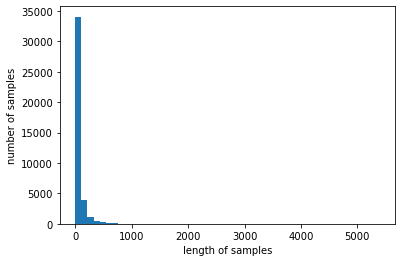

In [33]:
print('train data의 최대 길이 :',max(len(l) for l in del_x_train))
print('train data의 평균 길이 :',sum(map(len, del_x_train))/len(del_x_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 청원의 길이는 5394이며, 평균 길이는 67이다

test data의 최대 길이 : 3850
test data의 평균 길이 : 66.7554


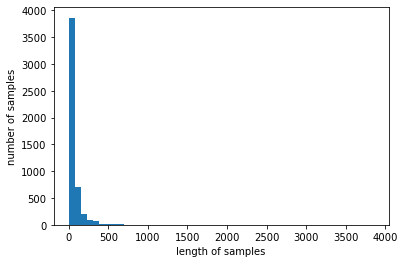

In [34]:
print('test data의 최대 길이 :',max(len(l) for l in test_sequences))
print('test data의 평균 길이 :',sum(map(len, test_sequences))/len(test_sequences))
plt.hist([len(s) for s in test_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 패딩을 하기 전 2가지 가정을 함

1. max_len을 문서의 최대 길이인 5394에 맞출 경우


2. 문서의 대체적인 길이가 67임을 고려하여 전반적인 문서 비율을 만족하는 max_len을 임의로 지정하는 경우(test data의 최대 길이는 3850이며 문서의 길이 편차가 큼) 

In [35]:
# 첫 번째 가정 실행 
max_len = 5394
train_data1 = pad_sequences(del_x_train, maxlen = max_len)
test_data1 = pad_sequences(test_sequences, maxlen = max_len)
print("train 데이터의 크기(shape): ", train_data1.shape)
print("test 데이터의 크기(shape): ", test_data1.shape)

train 데이터의 크기(shape):  (39963, 5394)
test 데이터의 크기(shape):  (5000, 5394)


### Model 1(Simple RNN)

In [36]:
model = Sequential()
model.add(Embedding(vocab_size , 64, input_length = max_len))
model.add(SimpleRNN(64))
model.add(Dense(3, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5394, 64)          2787776   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 2,796,227
Trainable params: 2,796,227
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics= 'accuracy')
early_stopping = EarlyStopping(monitor = 'val_acc', patience = 3) # 검증 데이터 손실이 3회 증가하면 멈춤

~~~python
history1 = model.fit(train_data1, del_y_train, 
                     epochs = 40, 
                     batch_size = 64, 
                     shuffle = True,
                     validation_split = 0.2,
                     verbose = 1, 
                     callbacks = early_stopping )
~~~

#### maxlen을 500으로 임의 지정

In [38]:
# 두 번째 가정 실행 
max_len = 500
train_data2 = pad_sequences(del_x_train, maxlen = max_len)
test_data2 = pad_sequences(test_sequences, maxlen = max_len)
print("train 데이터의 크기(shape): ", train_data2.shape)
print("test 데이터의 크기(shape): ", test_data2.shape)

train 데이터의 크기(shape):  (39963, 500)
test 데이터의 크기(shape):  (5000, 500)


In [39]:
model1 = Sequential()
model1.add(Embedding(vocab_size , 64, input_length = max_len))
model1.add(SimpleRNN(64))
model1.add(Dense(3, activation = 'softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           2787776   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,796,227
Trainable params: 2,796,227
Non-trainable params: 0
_________________________________________________________________


In [40]:
model1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics= 'accuracy')
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

In [41]:
history2 = model1.fit(train_data2, del_y_train, 
                     epochs = 40, 
                     batch_size = 64, 
                     shuffle = True,
                     validation_split = 0.2,
                     verbose = 1, 
                     callbacks = early_stopping )

Epoch 1/40
500/500 [==============================] - 77s 152ms/step - loss: 0.5954 - accuracy: 0.7454 - val_loss: 0.4478 - val_accuracy: 0.8389
Epoch 2/40
500/500 [==============================] - 74s 147ms/step - loss: 0.3400 - accuracy: 0.8718 - val_loss: 0.4794 - val_accuracy: 0.8236
Epoch 3/40
500/500 [==============================] - 74s 147ms/step - loss: 0.2588 - accuracy: 0.9032 - val_loss: 0.4160 - val_accuracy: 0.8541
Epoch 4/40
500/500 [==============================] - 74s 148ms/step - loss: 0.2401 - accuracy: 0.9114 - val_loss: 0.4613 - val_accuracy: 0.8395
Epoch 5/40
500/500 [==============================] - 74s 149ms/step - loss: 0.1534 - accuracy: 0.9411 - val_loss: 0.5289 - val_accuracy: 0.8304
Epoch 6/40
500/500 [==============================] - 75s 151ms/step - loss: 0.1042 - accuracy: 0.9607 - val_loss: 0.5839 - val_accuracy: 0.8292
Epoch 7/40
500/500 [==============================] - 75s 149ms/step - loss: 0.0739 - accuracy: 0.9715 - val_loss: 0.6799 - val_ac

## Model 2 (1D CNN)

In [42]:
model2 = Sequential()
model2.add(Embedding(vocab_size,64,input_length = max_len)) # maxlen = 500, batch_size = 64
model2.add(Dropout(0.2))
model2.add(Conv1D(32,5,strides = 1, padding = 'same', activation = 'relu')) # padding : same 출력이미지가 입력이미지와 같은 사이즈
model2.add(GlobalMaxPooling1D()) # 이미지 전역에 pooling
model2.add(Dense(3, activation = 'softmax')) # 카테고리가 0,1,2이므로 밀집층이 3인 softmax
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 64)           2787776   
_________________________________________________________________
dropout (Dropout)            (None, 500, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           10272     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 2,798,147
Trainable params: 2,798,147
Non-trainable params: 0
_________________________________________________________________


In [43]:
model2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics= 'accuracy')
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)

In [44]:
history2 = model2.fit(train_data2, del_y_train, 
                     epochs = 40, 
                     batch_size = 64, 
                     shuffle = True,
                     validation_split = 0.2,
                     verbose = 1, 
                     callbacks = early_stopping )

Epoch 1/40
500/500 [==============================] - 46s 89ms/step - loss: 0.4997 - accuracy: 0.8146 - val_loss: 0.3476 - val_accuracy: 0.8648
Epoch 2/40
500/500 [==============================] - 44s 89ms/step - loss: 0.3222 - accuracy: 0.8758 - val_loss: 0.3311 - val_accuracy: 0.8685
Epoch 3/40
500/500 [==============================] - 45s 90ms/step - loss: 0.2912 - accuracy: 0.8881 - val_loss: 0.3242 - val_accuracy: 0.8724
Epoch 4/40
500/500 [==============================] - 44s 88ms/step - loss: 0.2700 - accuracy: 0.8961 - val_loss: 0.3223 - val_accuracy: 0.8751
Epoch 5/40
500/500 [==============================] - 44s 88ms/step - loss: 0.2508 - accuracy: 0.9056 - val_loss: 0.3186 - val_accuracy: 0.8755
Epoch 6/40
500/500 [==============================] - 44s 88ms/step - loss: 0.2323 - accuracy: 0.9124 - val_loss: 0.3207 - val_accuracy: 0.8775
Epoch 7/40
500/500 [==============================] - 44s 88ms/step - loss: 0.2153 - accuracy: 0.9200 - val_loss: 0.3290 - val_accuracy:

## Model 3 

In [45]:
model3 = Sequential()
model3.add(Embedding(vocab_size,64,input_length = max_len))
model3.add(Dropout(0.2))
model3.add(Conv1D(32,5,strides = 1, padding = 'same', activation = 'relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(64, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(3, activation = 'softmax'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 64)           2787776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           10272     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                

In [46]:
model3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= 'accuracy')
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)

In [47]:
history3 = model3.fit(train_data2, del_y_train, 
                     epochs = 40, 
                     batch_size = 64, 
                     shuffle = True,
                     validation_split = 0.2,
                     verbose = 1, 
                     callbacks = early_stopping )

Epoch 1/40
500/500 [==============================] - 57s 113ms/step - loss: 0.4878 - accuracy: 0.8056 - val_loss: 0.3337 - val_accuracy: 0.8678
Epoch 2/40
500/500 [==============================] - 54s 108ms/step - loss: 0.2633 - accuracy: 0.9009 - val_loss: 0.3256 - val_accuracy: 0.8729
Epoch 3/40
500/500 [==============================] - 55s 110ms/step - loss: 0.1748 - accuracy: 0.9351 - val_loss: 0.3565 - val_accuracy: 0.8686
Epoch 4/40
500/500 [==============================] - 56s 112ms/step - loss: 0.1138 - accuracy: 0.9575 - val_loss: 0.4008 - val_accuracy: 0.8655
Epoch 5/40
500/500 [==============================] - 58s 115ms/step - loss: 0.0740 - accuracy: 0.9717 - val_loss: 0.4532 - val_accuracy: 0.8641


## Model 4(Conv1D + LSTM)

In [48]:
model4 = Sequential()
model4.add(Embedding(vocab_size,64,input_length = max_len))
model4.add(Dropout(0.2))
model4.add(Conv1D(32,5,strides = 1, padding = 'same', activation = 'relu'))
model4.add(MaxPooling1D(pool_size = 4))
model4.add(LSTM(32))
model4.add(Dense(32, activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Dense(3, activation = 'softmax'))
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 64)           2787776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           10272     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 125, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

In [49]:
model4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= 'accuracy')
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min')

In [50]:
history4 = model4.fit(train_data2, del_y_train, 
                     epochs = 40, 
                     batch_size = 64, 
                     shuffle = True,
                     validation_split = 0.2,
                     verbose = 1, 
                     callbacks = early_stopping )

Epoch 1/40
500/500 [==============================] - 86s 168ms/step - loss: 0.4644 - accuracy: 0.8135 - val_loss: 0.3260 - val_accuracy: 0.8746
Epoch 2/40
500/500 [==============================] - 86s 172ms/step - loss: 0.2589 - accuracy: 0.9050 - val_loss: 0.3377 - val_accuracy: 0.8720
Epoch 3/40
500/500 [==============================] - 80s 160ms/step - loss: 0.1912 - accuracy: 0.9297 - val_loss: 0.3891 - val_accuracy: 0.8675
Epoch 4/40
500/500 [==============================] - 80s 161ms/step - loss: 0.1469 - accuracy: 0.9453 - val_loss: 0.4285 - val_accuracy: 0.8614


## Model 5 : maxlen을 줄이기, Optimizer 변경(RmsProp, lr = 0.001)

### 이하 층은 Model2와 Model4 동일

In [60]:
max_len = 300
train_data3 = pad_sequences(del_x_train, maxlen = max_len)
test_data3 = pad_sequences(test_sequences, maxlen = max_len)
print("train 데이터의 크기(shape): ", train_data3.shape)
print("test 데이터의 크기(shape): ", test_data3.shape)

train 데이터의 크기(shape):  (39963, 300)
test 데이터의 크기(shape):  (5000, 300)


In [61]:
model2 = Sequential()
model2.add(Embedding(vocab_size,64,input_length = max_len)) # maxlen = 500, batch_size = 64
model2.add(Dropout(0.2))
model2.add(Conv1D(32,5,strides = 1, padding = 'same', activation = 'relu')) # padding : same 출력이미지가 입력이미지와 같은 사이즈
model2.add(GlobalMaxPooling1D()) # 이미지 전역에 pooling
model2.add(Dense(3, activation = 'softmax')) # 카테고리가 0,1,2이므로 밀집층이 3인 softmax
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 64)           2787776   
_________________________________________________________________
dropout_5 (Dropout)          (None, 300, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 300, 32)           10272     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 2,798,147
Trainable params: 2,798,147
Non-trainable params: 0
_________________________________________________________________


In [62]:
model2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics= 'accuracy')
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)

In [63]:
history2 = model2.fit(train_data3, del_y_train, 
                     epochs = 40, 
                     batch_size = 64, 
                     shuffle = True,
                     validation_split = 0.2,
                     verbose = 1, 
                     callbacks = early_stopping )

Epoch 1/40
500/500 [==============================] - 32s 64ms/step - loss: 0.4991 - accuracy: 0.8179 - val_loss: 0.3466 - val_accuracy: 0.8661
Epoch 2/40
500/500 [==============================] - 32s 63ms/step - loss: 0.3175 - accuracy: 0.8779 - val_loss: 0.3319 - val_accuracy: 0.8723
Epoch 3/40
500/500 [==============================] - 31s 62ms/step - loss: 0.2863 - accuracy: 0.8885 - val_loss: 0.3239 - val_accuracy: 0.8734
Epoch 4/40
500/500 [==============================] - 31s 62ms/step - loss: 0.2612 - accuracy: 0.9000 - val_loss: 0.3273 - val_accuracy: 0.8738
Epoch 5/40
500/500 [==============================] - 31s 63ms/step - loss: 0.2407 - accuracy: 0.9081 - val_loss: 0.3297 - val_accuracy: 0.8756
Epoch 6/40
500/500 [==============================] - 32s 63ms/step - loss: 0.2203 - accuracy: 0.9170 - val_loss: 0.3369 - val_accuracy: 0.8721


## Model 6

- 여전히 88퍼를 넘지 못했음.

In [92]:
model6 = Sequential()
model6.add(Embedding(vocab_size,64,input_length = max_len))
model6.add(Dropout(0.2))
model6.add(Conv1D(32,5,strides = 1, padding = 'same', activation = 'relu'))
model6.add(MaxPooling1D(pool_size = 4))
model6.add(LSTM(32,dropout = 0.3))
model6.add(Dense(32, activation = 'relu'))
model6.add(Dropout(0.2))
model6.add(Dense(3, activation = 'softmax'))
model6.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 64)           2787776   
_________________________________________________________________
dropout_17 (Dropout)         (None, 300, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 300, 32)           10272     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 75, 32)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)              

In [93]:
rmsprop = RMSprop(learning_rate = 0.001)
model6.compile(optimizer = rmsprop, loss = 'categorical_crossentropy', metrics= 'accuracy')
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True)

In [94]:
history6 = model6.fit(train_data3, del_y_train, 
                     epochs = 40, 
                     batch_size = 64, 
                     shuffle = True,
                     validation_split = 0.2,
                     verbose = 1, 
                     callbacks = early_stopping )

Epoch 1/40
500/500 [==============================] - 48s 91ms/step - loss: 0.4770 - accuracy: 0.8122 - val_loss: 0.3241 - val_accuracy: 0.8785
Epoch 2/40
500/500 [==============================] - 50s 101ms/step - loss: 0.3082 - accuracy: 0.8862 - val_loss: 0.3164 - val_accuracy: 0.8818
Epoch 3/40
500/500 [==============================] - 49s 97ms/step - loss: 0.2748 - accuracy: 0.8968 - val_loss: 0.3183 - val_accuracy: 0.8766
Epoch 4/40
500/500 [==============================] - 48s 95ms/step - loss: 0.2547 - accuracy: 0.9067 - val_loss: 0.3192 - val_accuracy: 0.8813
Epoch 5/40
500/500 [==============================] - 47s 94ms/step - loss: 0.2370 - accuracy: 0.9126 - val_loss: 0.3280 - val_accuracy: 0.8789


## 제출

In [95]:
#pred = model6.predict(test_data3)

In [96]:
#pred

array([[6.0932505e-01, 8.7116919e-03, 3.8196325e-01],
       [6.3895234e-03, 1.5313505e-03, 9.9207908e-01],
       [8.0540683e-03, 9.9137294e-01, 5.7309511e-04],
       ...,
       [4.1792467e-03, 9.9557209e-01, 2.4867270e-04],
       [9.7307998e-01, 2.1300290e-02, 5.6197313e-03],
       [2.7036933e-02, 9.0598844e-02, 8.8236427e-01]], dtype=float32)

In [97]:
#submission = pd.read_csv('sample_submission.csv')

In [98]:
#submission['category'] = np.argmax(pred,axis = -1)

In [99]:
#submission

,index,category
0,0,0
1,1,2
2,2,1
3,3,1
4,4,2
...,...,...
4995,4995,0
4996,4996,1
4997,4997,1
4998,4998,0


In [100]:
#submission.to_csv("submission.csv", index = False)